# kladversie depth map overlay met originele 2D afbeelding - morgen cleanup

In [1]:
import numpy as np
import os
import struct
import matplotlib.pyplot as plt
import imageio


In [2]:
def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(
            fid, delimiter="&", max_rows=1, usecols=(0, 1, 2), dtype=int
        )
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()

def write_array(array, path):
    assert array.dtype == np.float32
    if len(array.shape) == 2:
        height, width = array.shape
        channels = 1
    elif len(array.shape) == 3:
        height, width, channels = array.shape
    else:
        assert False

    with open(path, "w") as fid:
        fid.write(str(width) + "&" + str(height) + "&" + str(channels) + "&")

    with open(path, "ab") as fid:
        if len(array.shape) == 2:
            array_trans = np.transpose(array, (1, 0))
        elif len(array.shape) == 3:
            array_trans = np.transpose(array, (1, 0, 2))
        else:
            assert False
        data_1d = array_trans.reshape(-1, order="F")
        data_list = data_1d.tolist()
        endian_character = "<"
        format_char_sequence = "".join(["f"] * len(data_list))
        byte_data = struct.pack(
            endian_character + format_char_sequence, *data_list
        )
        fid.write(byte_data)


In [9]:
# Set the file paths for the depth and normal maps
file_name = 'eastbound_20240319_07851.png.geometric.bin'
# file_name = 'eastbound_20240319_08026.png.geometric.bin'
depth_map_path = 'dense/stereo/depth_maps/eastbound/' + file_name  # Change this to your actual file path
normal_map_path = 'dense/stereo/normal_maps/eastbound/' + file_name  # Change this to your actual file path

# Set the visualization parameters
min_depth_percentile = 5
max_depth_percentile = 95


In [10]:
# Check if files exist
if not os.path.exists(depth_map_path):
    raise FileNotFoundError(f"File not found: {depth_map_path}")

if not os.path.exists(normal_map_path):
    raise FileNotFoundError(f"File not found: {normal_map_path}")

# Read depth and normal maps
depth_map = read_array(depth_map_path)
normal_map = read_array(normal_map_path)

# Process the depth map based on percentiles
min_depth, max_depth = np.percentile(depth_map, [min_depth_percentile, max_depth_percentile])
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth


In [13]:
depth_map.shape

(1348, 2400)

In [14]:
original_image.shape

(1520, 2704, 3)

In [15]:
1348/2400

0.5616666666666666

In [16]:
1520/2704

0.5621301775147929

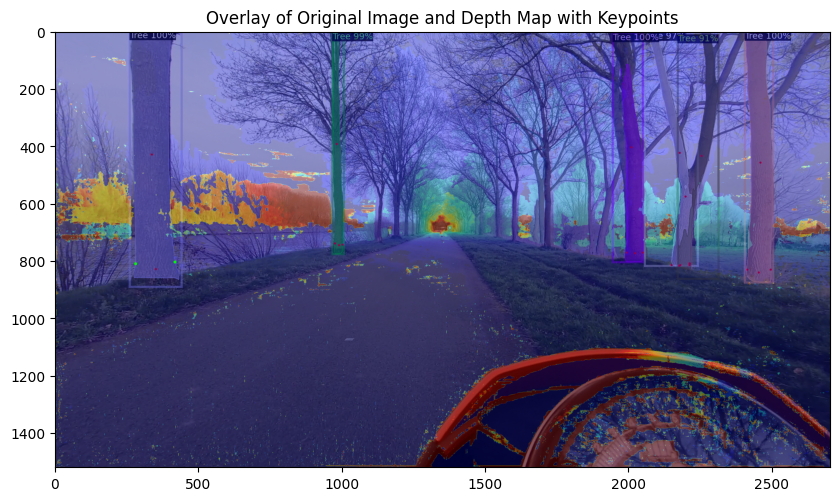

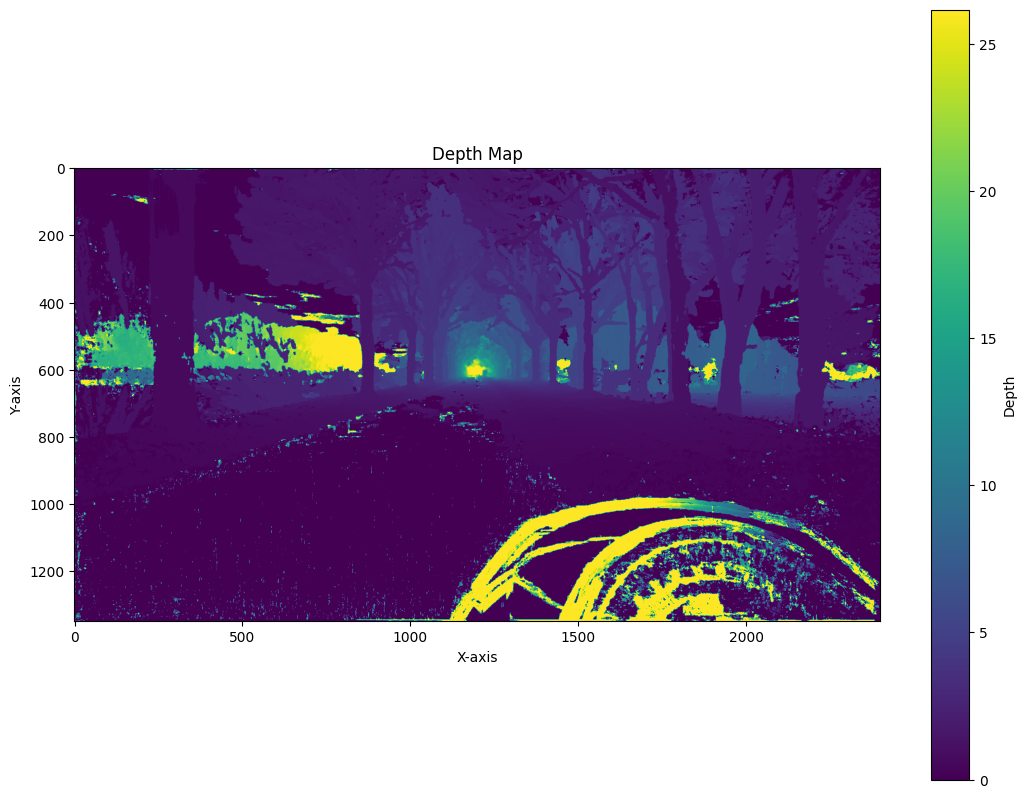

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original 2D image and the depth map
original_image = cv2.imread('eastbound_20240319_07851.png')

# Resize the depth map to match the dimensions of the original image
# depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]))
depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Normalize the depth map for visualization (optional)
depth_map_normalized = cv2.normalize(depth_map_resized, None, 0, 255, cv2.NORM_MINMAX)
depth_map_normalized = depth_map_normalized.astype(np.uint8)

# Convert depth map to a color map
depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

# Overlay the depth map onto the original image
overlay = cv2.addWeighted(original_image, 0.6, depth_map_colored, 0.4, 0)

# Define keypoints (example coordinates)
left_point = (281, 811)
right_point = (418, 805)
keypoints = [
    left_point,
    right_point
]

# Add keypoints to the overlay image
for point in keypoints:
    cv2.circle(overlay, point, 5, (0, 255, 0), -1)

# Convert BGR image to RGB for displaying with matplotlib
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display the overlay image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(overlay_rgb)
plt.title('Overlay of Original Image and Depth Map with Keypoints')
# plt.axis('off')
plt.show()


# Visualize the depth map
plt.figure(figsize=(13, 10))
plt.imshow(depth_map)
plt.colorbar(label='Depth')
plt.title("Depth Map")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
eastbound_20240319_08051.png

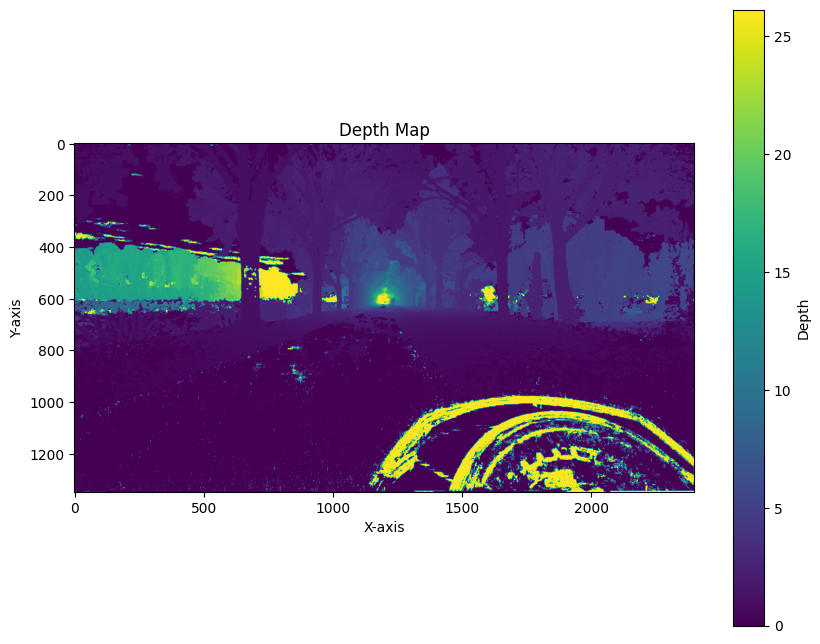

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


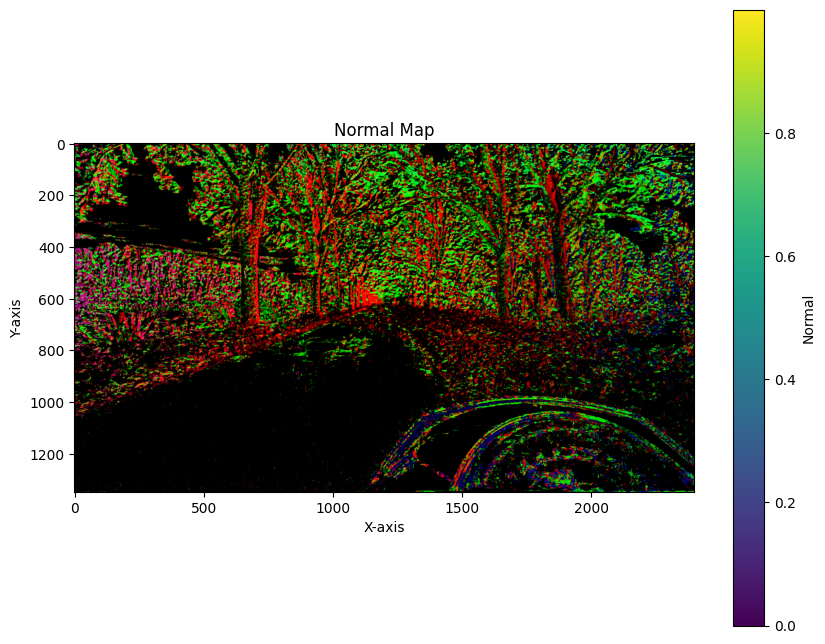

In [8]:
# Visualize the depth map
plt.figure(figsize=(10, 8))
plt.imshow(depth_map, cmap='viridis')
plt.colorbar(label='Depth')
plt.title("Depth Map")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Visualize the normal map
plt.figure(figsize=(10, 8))
plt.imshow(normal_map)
plt.colorbar(label='Normal')
plt.title("Normal Map")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
